# Convolutional Neural Networks
(c) Deniz Yuret, 2019
* Objectives: See the effect of sparse and shared weights implemented by convolutional networks.
* Prerequisites: [MLP models](40.mlp.ipynb), [MNIST](20.mnist.ipynb)
* New functions:
[conv4](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.conv4),
[pool](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.pool),
[mat](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.mat)

![image](https://github.com/denizyuret/Knet.jl/blob/master/docs/src/images/le_net.png?raw=true)
([image source](http://www.dataiku.com/blog/2015/08/18/Deep_Learning.html))

To improve the performance further, we can use a convolutional neural networks (CNN). See the [course notes](http://cs231n.github.io/convolutional-networks/) by Andrej Karpathy for a good introduction to CNNs. We will implement the [LeNet](http://yann.lecun.com/exdb/lenet) model which consists of two convolutional layers followed by two fully connected layers. We will describe and use the [conv4](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.conv4) and [pool](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.pool) functions provided by Knet for the implementation of convolutional nets.

Even though MLPs and CNNs are both universal function approximators and both achieve 0 error on the training set, we will see that a CNN converges a lot faster and generalizes a lot better with less overfitting achieving a 99.5% test accuracy on MNIST. The sparse connectivity and shared weights of a CNN give it an inductive bias appropriate for image features allowing it to learn better with less data.

In [1]:
# Setup display width, load packages, import symbols
ENV["COLUMNS"]=72
using Pkg; for p in ("Knet","IterTools","Plots"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Statistics: mean
using Knet: Knet, conv4, pool, mat, KnetArray, nll, zeroone, progress, sgd, param, param0, dropout, relu, Data, gpu

## Introduction to convolution

In [2]:
# Convolution operator in Knet
@doc conv4

```
conv4(w, x; kwargs...)
```

Execute convolutions or cross-correlations using filters specified with `w` over tensor `x`.

Currently KnetArray{Float32/64,4/5} and Array{Float32/64,4} are supported as `w` and `x`.  If `w` has dimensions `(W1,W2,...,I,O)` and `x` has dimensions `(X1,X2,...,I,N)`, the result `y` will have dimensions `(Y1,Y2,...,O,N)` where

```
Yi=1+floor((Xi+2*padding[i]-Wi)/stride[i])
```

Here `I` is the number of input channels, `O` is the number of output channels, `N` is the number of instances, and `Wi,Xi,Yi` are spatial dimensions.  `padding` and `stride` are keyword arguments that can be specified as a single number (in which case they apply to all dimensions), or an array/tuple with entries for each spatial dimension.

# Keywords

  * `padding=0`: the number of extra zeros implicitly concatenated at the start and at the end of each dimension.
  * `stride=1`: the number of elements to slide to reach the next filtering window.
  * `dilation=1`: dilation factor for each dimension.
  * `mode=0`: 0 for convolution and 1 for cross-correlation.
  * `alpha=1`: can be used to scale the result.
  * `handle`: handle to a previously created cuDNN context. Defaults to a Knet allocated handle.


In [3]:
# Convolution in 1-D
w = reshape([1.0,2.0,3.0], (3,1,1,1)); @show w
x = reshape([1.0:7.0...], (7,1,1,1)); @show x
@show y = conv4(w, x);  # size Y = X - W + 1 = 5 by default

w = [1.0; 2.0; 3.0]
x = [1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0]
y = conv4(w, x) = [10.0; 16.0; 22.0; 28.0; 34.0]


In [4]:
# Padding
w = reshape([1.0,2.0,3.0], (3,1,1,1)); @show w
x = reshape([1.0:7.0...], (7,1,1,1)); @show x
@show y2 = conv4(w, x, padding=(1,0));  # size Y = X + 2P - W + 1 = 7 with padding=1
# To preserve input size (Y=X) for a given W, what padding P should we use?

w = [1.0; 2.0; 3.0]
x = [1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0]
y2 = conv4(w, x, padding=(1, 0)) = [4.0; 10.0; 16.0; 22.0; 28.0; 34.0; 32.0]


In [5]:
# Stride
w = reshape([1.0,2.0,3.0], (3,1,1,1)); @show w
x = reshape([1.0:7.0...], (7,1,1,1)); @show x
@show y3 = conv4(w, x; padding=(1,0), stride=3);  # size Y = 1 + floor((X+2P-W)/S)

w = [1.0; 2.0; 3.0]
x = [1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0]
y3 = conv4(w, x; padding=(1, 0), stride=3) = [4.0; 22.0; 32.0]


In [6]:
# Mode
w = reshape([1.0,2.0,3.0], (3,1,1,1)); @show w
x = reshape([1.0:7.0...], (7,1,1,1)); @show x
@show y4 = conv4(w, x, mode=0);  # Default mode (convolution) inverts w
@show y5 = conv4(w, x, mode=1);  # mode=1 (cross-correlation) does not invert w

w = [1.0; 2.0; 3.0]
x = [1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0]
y4 = conv4(w, x, mode=0) = [10.0; 16.0; 22.0; 28.0; 34.0]
y5 = conv4(w, x, mode=1) = [14.0; 20.0; 26.0; 32.0; 38.0]


In [7]:
# Convolution in more dimensions
x = reshape([1.0:9.0...], (3,3,1,1))

3×3×1×1 Array{Float64,4}:
[:, :, 1, 1] =
 1.0  4.0  7.0
 2.0  5.0  8.0
 3.0  6.0  9.0

In [8]:
w = reshape([1.0:4.0...], (2,2,1,1))

2×2×1×1 Array{Float64,4}:
[:, :, 1, 1] =
 1.0  3.0
 2.0  4.0

In [9]:
y = conv4(w, x)

2×2×1×1 Array{Float64,4}:
[:, :, 1, 1] =
 23.0  53.0
 33.0  63.0

In [10]:
# Convolution with multiple channels, filters, and instances
# size X = [X1,X2,...,Xd,Cx,N] where d is the number of dimensions, Cx is channels, N is instances
x = reshape([1.0:18.0...], (3,3,2,1)) 

3×3×2×1 Array{Float64,4}:
[:, :, 1, 1] =
 1.0  4.0  7.0
 2.0  5.0  8.0
 3.0  6.0  9.0

[:, :, 2, 1] =
 10.0  13.0  16.0
 11.0  14.0  17.0
 12.0  15.0  18.0

In [11]:
# size W = [W1,W2,...,Wd,Cx,Cy] where d is the number of dimensions, Cx is input channels, Cy is output channels
w = reshape([1.0:24.0...], (2,2,2,3));

In [12]:
# size Y = [Y1,Y2,...,Yd,Cy,N]  where Yi = 1 + floor((Xi+2Pi-Wi)/Si), Cy is channels, N is instances
y = conv4(w,x)

2×2×3×1 Array{Float64,4}:
[:, :, 1, 1] =
 328.0  436.0
 364.0  472.0

[:, :, 2, 1] =
 808.0  1108.0
 908.0  1208.0

[:, :, 3, 1] =
 1288.0  1780.0
 1452.0  1944.0

See http://cs231n.github.io/assets/conv-demo/index.html for an animated example.

## Introduction to Pooling

In [13]:
# Pooling operator in Knet
@doc pool

```
pool(x; kwargs...)
```

Compute pooling of input values (i.e., the maximum or average of several adjacent values) to produce an output with smaller height and/or width.

Currently 4 or 5 dimensional KnetArrays with `Float32` or `Float64` entries are supported.  If `x` has dimensions `(X1,X2,...,I,N)`, the result `y` will have dimensions `(Y1,Y2,...,I,N)` where

```
Yi=1+floor((Xi+2*padding[i]-window[i])/stride[i])
```

Here `I` is the number of input channels, `N` is the number of instances, and `Xi,Yi` are spatial dimensions.  `window`, `padding` and `stride` are keyword arguments that can be specified as a single number (in which case they apply to all dimensions), or an array/tuple with entries for each spatial dimension.

# Keywords:

  * `window=2`: the pooling window size for each dimension.
  * `padding=0`: the number of extra zeros implicitly concatenated at the start and at the end of each dimension.
  * `stride=window`: the number of elements to slide to reach the next pooling window.
  * `mode=0`: 0 for max, 1 for average including padded values, 2 for average excluding padded values.
  * `maxpoolingNanOpt=0`: Nan numbers are not propagated if 0, they are propagated if 1.
  * `alpha=1`: can be used to scale the result.
  * `handle`: Handle to a previously created cuDNN context. Defaults to a Knet allocated handle.


In [14]:
# 1-D pooling example
x = reshape([1.0:6.0...], (6,1,1,1)); @show x
@show pool(x; window=(2,1));

x = [1.0; 2.0; 3.0; 4.0; 5.0; 6.0]
pool(x; window=(2, 1)) = [2.0; 4.0; 6.0]


In [15]:
# Window size
x = reshape([1.0:6.0...], (6,1,1,1)); @show x
@show pool(x; window=(3,1));  # size Y = floor(X/W)

x = [1.0; 2.0; 3.0; 4.0; 5.0; 6.0]
pool(x; window=(3, 1)) = [3.0; 6.0]


In [16]:
# Padding
x = reshape([1.0:6.0...], (6,1,1,1)); @show x
@show pool(x; window=(2,1), padding=(1,0));  # size Y = floor((X+2P)/W)

x = [1.0; 2.0; 3.0; 4.0; 5.0; 6.0]
pool(x; window=(2, 1), padding=(1, 0)) = [1.0; 3.0; 5.0; 6.0]


In [17]:
# Stride
x = reshape([1.0:10.0...], (10,1,1,1)); @show x
@show pool(x; window=(2,1), stride=4);  # size Y = 1 + floor((X+2P-W)/S)

x = [1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0; 9.0; 10.0]
pool(x; window=(2, 1), stride=4) = [2.0; 6.0; 10.0]


In [18]:
# Mode (using KnetArray here; not all modes are implemented on the CPU)
if gpu() >= 0
    x = KnetArray(reshape([1.0:6.0...], (6,1,1,1))); @show x
    @show pool(x; padding=(1,0), mode=0)  # max pooling
    @show pool(x; padding=(1,0), mode=1)  # avg pooling
    @show pool(x; padding=(1,0), mode=2); # avg pooling excluding padded values (is not implemented on CPU)
end

x = K64(6,1,1,1)[1.0⋯]
pool(x; padding=(1, 0), mode=0) = K64(4,1,1,1)[1.0⋯]
pool(x; padding=(1, 0), mode=1) = K64(4,1,1,1)[0.5⋯]
pool(x; padding=(1, 0), mode=2) = K64(4,1,1,1)[1.0⋯]


4×1×1×1 KnetArray{Float64,4}:
[:, :, 1, 1] =
 1.0
 2.5
 4.5
 6.0

In [19]:
# More dimensions
x = reshape([1.0:16.0...], (4,4,1,1))

4×4×1×1 Array{Float64,4}:
[:, :, 1, 1] =
 1.0  5.0   9.0  13.0
 2.0  6.0  10.0  14.0
 3.0  7.0  11.0  15.0
 4.0  8.0  12.0  16.0

In [20]:
pool(x)

2×2×1×1 Array{Float64,4}:
[:, :, 1, 1] =
 6.0  14.0
 8.0  16.0

In [21]:
# Multiple channels and instances
x = reshape([1.0:32.0...], (4,4,2,1))

4×4×2×1 Array{Float64,4}:
[:, :, 1, 1] =
 1.0  5.0   9.0  13.0
 2.0  6.0  10.0  14.0
 3.0  7.0  11.0  15.0
 4.0  8.0  12.0  16.0

[:, :, 2, 1] =
 17.0  21.0  25.0  29.0
 18.0  22.0  26.0  30.0
 19.0  23.0  27.0  31.0
 20.0  24.0  28.0  32.0

In [22]:
# each channel and each instance is pooled separately
pool(x)  # size Y = (Y1,...,Yd,Cx,N) where Yi are spatial dims, Cx and N are identical to input X

2×2×2×1 Array{Float64,4}:
[:, :, 1, 1] =
 6.0  14.0
 8.0  16.0

[:, :, 2, 1] =
 22.0  30.0
 24.0  32.0

## Experiment setup

In [23]:
# Load data (see mnist.ipynb)
include(Knet.dir("data","mnist.jl"))  # Load data
dtrn,dtst = mnistdata();              # dtrn and dtst = [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100

┌ Info: Loading MNIST...
└ @ Main /kuacc/users/dyuret/.julia/dev/Knet/data/mnist.jl:33


In [24]:
(x,y) = first(dtst)
println.(summary.((x,y)));

28×28×1×100 KnetArray{Float32,4}
100-element Array{UInt8,1}


In [25]:
# For running experiments
function trainresults(file,model; o...)
    if (print("Train from scratch? "); readline()[1]=='y')
        r = ((model(dtrn), model(dtst), zeroone(model,dtrn), zeroone(model,dtst))
             for x in takenth(progress(sgd(model,ncycle(dtrn,100))),length(dtrn)))
        r = reshape(collect(Float32,flatten(r)),(4,:))
        Knet.save(file,"results",r)
        Knet.gc() # To save gpu memory
    else
        isfile(file) || download("http://people.csail.mit.edu/deniz/models/tutorial/$file",file)
        r = Knet.load(file,"results")
    end
    println(minimum(r,dims=2))
    return r
end

trainresults (generic function with 1 method)

## A convolutional neural network model for MNIST

In [26]:
# Define a convolutional layer:
struct Conv; w; b; f; p; end
(c::Conv)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p)) .+ c.b))
Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

Conv

In [27]:
# Redefine dense layer (See mlp.ipynb):
struct Dense; w; b; f; p; end
(d::Dense)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Dense(i::Int,o::Int,f=relu;pdrop=0) = Dense(param(o,i), param0(o), f, pdrop)

Dense

In [28]:
# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)

In [29]:
lenet =   Chain(Conv(5,5,1,20), 
                Conv(5,5,20,50), 
                Dense(800,500,pdrop=0.3), 
                Dense(500,10,identity,pdrop=0.3))
summary.(l.w for l in lenet.layers)

4-element Array{String,1}:
 "5×5×1×20 AutoGrad.Param{KnetArray{Float32,4}}" 
 "5×5×20×50 AutoGrad.Param{KnetArray{Float32,4}}"
 "500×800 AutoGrad.Param{KnetArray{Float32,2}}"  
 "10×500 AutoGrad.Param{KnetArray{Float32,2}}"   

In [30]:
lenet(x,y)

2.2864733f0

## CNN vs MLP

In [31]:
# 1.08e-02  100.00%┣████████████████▉┫ 60000/60000 [03:50/03:50, 260.67i/s]
# [0.000135032; 0.0196918; 0.0; 0.0053]
cnn = trainresults("cnn113.jld2", lenet);

Train from scratch? stdin> n
Float32[0.00014203013; 0.018552596; 0.0; 0.0041]


In [32]:
mlp = Knet.load("mlp113f.jld2","results");

In [33]:
using Plots; default(fmt=:png,ls=:auto)

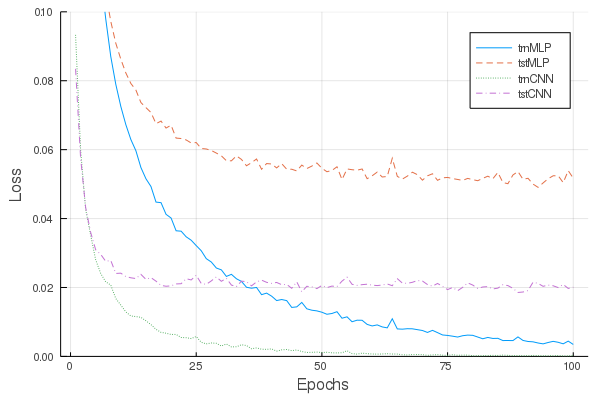

In [34]:
# Comparison to MLP shows faster convergence, better generalization
plot([mlp[1,:], mlp[2,:], cnn[1,:], cnn[2,:]],ylim=(0.0,0.1),
     labels=[:trnMLP :tstMLP :trnCNN :tstCNN],xlabel="Epochs",ylabel="Loss")  

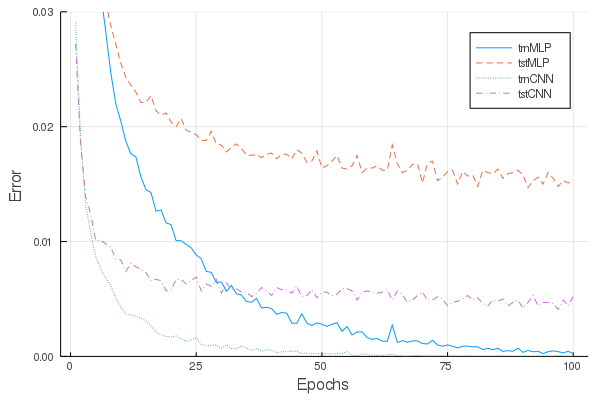

In [35]:
plot([mlp[3,:], mlp[4,:], cnn[3,:], cnn[4,:]],ylim=(0.0,0.03),
    labels=[:trnMLP :tstMLP :trnCNN :tstCNN],xlabel="Epochs",ylabel="Error")  

## Convolution vs Matrix Multiplication

In [36]:
# Convolution and matrix multiplication can be implemented in terms of each other.
# Convolutional networks have no additional representational power, only statistical efficiency.
# Our original 1-D example
@show w = reshape([1.0,2.0,3.0], (3,1,1,1))
@show x = reshape([1.0:7.0...], (7,1,1,1))
@show y = conv4(w, x);  # size Y = X - W + 1 = 5 by default

w = reshape([1.0, 2.0, 3.0], (3, 1, 1, 1)) = [1.0; 2.0; 3.0]
x = reshape([1.0:7.0...], (7, 1, 1, 1)) = [1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0]
y = conv4(w, x) = [10.0; 16.0; 22.0; 28.0; 34.0]


In [37]:
# Convolution as matrix multiplication (1)
# Turn w into a (Y,X) sparse matrix
w2 = Float64[3 2 1 0 0 0 0; 0 3 2 1 0 0 0; 0 0 3 2 1 0 0; 0 0 0 3 2 1 0; 0 0 0 0 3 2 1]

5×7 Array{Float64,2}:
 3.0  2.0  1.0  0.0  0.0  0.0  0.0
 0.0  3.0  2.0  1.0  0.0  0.0  0.0
 0.0  0.0  3.0  2.0  1.0  0.0  0.0
 0.0  0.0  0.0  3.0  2.0  1.0  0.0
 0.0  0.0  0.0  0.0  3.0  2.0  1.0

In [38]:
@show y2 = w2 * mat(x);

y2 = w2 * mat(x) = [10.0; 16.0; 22.0; 28.0; 34.0]


In [39]:
# Convolution as matrix multiplication (2)
# Turn x into a (W,Y) dense matrix (aka the im2col operation)
# This is used to speed up convolution with known efficient matmul algorithms
x3 = Float64[1 2 3 4 5; 2 3 4 5 6; 3 4 5 6 7]

3×5 Array{Float64,2}:
 1.0  2.0  3.0  4.0  5.0
 2.0  3.0  4.0  5.0  6.0
 3.0  4.0  5.0  6.0  7.0

In [40]:
@show w3 = [3.0 2.0 1.0]
@show y3 = w3 * x3;

w3 = [3.0 2.0 1.0] = [3.0 2.0 1.0]
y3 = w3 * x3 = [10.0 16.0 22.0 28.0 34.0]


In [41]:
# Matrix multiplication as convolution
# This could be used to make a fully connected network accept variable sized inputs.
w = reshape([1.0:6.0...], (2,3))

2×3 Array{Float64,2}:
 1.0  3.0  5.0
 2.0  4.0  6.0

In [42]:
x = reshape([1.0:3.0...], (3,1))

3×1 Array{Float64,2}:
 1.0
 2.0
 3.0

In [43]:
y = w * x

2×1 Array{Float64,2}:
 22.0
 28.0

In [44]:
# Consider w with size (Y,X)
# Treat each of the Y rows of w as a convolution filter
w2 = copy(reshape(Array(w)', (3,1,1,2)))

3×1×1×2 Array{Float64,4}:
[:, :, 1, 1] =
 1.0
 3.0
 5.0

[:, :, 1, 2] =
 2.0
 4.0
 6.0

In [45]:
# Reshape x for convolution
x2 = reshape(x, (3,1,1,1))

3×1×1×1 Array{Float64,4}:
[:, :, 1, 1] =
 1.0
 2.0
 3.0

In [46]:
# Use conv4 for matrix multiplication
y2 = conv4(w2, x2; mode=1)

1×1×2×1 Array{Float64,4}:
[:, :, 1, 1] =
 22.0

[:, :, 2, 1] =
 28.0

* So there is no difference between the class of functions representable with an MLP vs CNN.
* Sparse connections and weight sharing give CNNs more generalization power with images.
* Number of parameters in MLP256: (256x784)+256+(10x256)+10 = 203530
* Number of parameters in LeNet: (5*5*1*20)+20+(5*5*20*50)+50+(500*800)+500+(10*500)+10 = 431080